# Toric code example

In this example, we'll use PyMatching to estimate the threshold of the toric code 
under an independent noise model with perfect syndrome measurements.
The decoding problem for the toric code is identical for $X$-type and $Z$-type 
errors, so we will only simulate decoding $Z$-type errors using $X$-type stabilisers in this example.

First, we will construct a check matrix $H_X$ corresponding to the $X$-type stabilisers.
Each element $H_X[i,j]$ will be 1 if the $i$th $X$ stabiliser acts non-trivially on 
the $j$th qubit, and is 0 otherwise.


We will construct $H_X$ by taking the [hypergraph product](https://arxiv.org/abs/0903.0566) of two repetition codes.
The hypergraph product code construction $HGP(H_1,H_2)$ takes as input the parity check 
matrices of two linear codes $C_1:=\ker H_1$ and $C_2:= \ker H_2$. The code $HGP(H_1,H_2)$ 
is a CSS code with the check matrix for the $X$ stabilisers given by

$$H_X=[H_1\otimes I_{n_2},I_{r_1}\otimes H_2^T]$$

and with the check matrix for the $Z$ stabilisers given by 

$$H_Z=[I_{n_1}\otimes H_2,H_1^T\otimes I_{r_2}]$$

where $H_1$ has dimensions $r_1\times n_1$, $H_2$ has dimensions $r_2\times n_2$ and $I_l$ denotes the $l\times l$ identity matrix.

Since we only need the $X$ stabilisers of the toric code with lattice size L, we only need to construct $H_X$, using the check matrix of a repetition code with length L for both $H_1$ and $H_2$:

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack, kron, eye, csc_matrix, block_diag


def repetition_code(n):
    """
    Parity check matrix of a repetition code with length n.
    """
    row_ind, col_ind = zip(*((i, j) for i in range(n) for j in (i, (i+1)%n)))
    data = np.ones(2*n, dtype=np.uint8)
    return csc_matrix((data, (row_ind, col_ind)))


def toric_code_x_stabilisers(L):
    """
    Sparse check matrix for the X stabilisers of a toric code with 
    lattice size L, constructed as the hypergraph product of 
    two repetition codes.
    """
    Hr = repetition_code(L)
    H = hstack(
            [kron(Hr, eye(Hr.shape[1])), kron(eye(Hr.shape[0]), Hr.T)],
            dtype=np.uint8
        )
    H.data = H.data % 2
    H.eliminate_zeros()
    return csc_matrix(H)

def toric_code_z_stabilisers(L):
    """
    Sparse check matrix for the Z stabilisers of a toric code with 
    lattice size L, constructed as the hypergraph product of 
    two repetition codes.
    """
    Hr = repetition_code(L)
    H = hstack(
            [kron(eye(Hr.shape[0]), Hr), kron(Hr.T, eye(Hr.shape[1]))],
            dtype=np.uint8
        )
    H.data = H.data % 2
    H.eliminate_zeros()
    return csc_matrix(H)

From the [K&uuml;nneth theorem](https://en.wikipedia.org/wiki/K%C3%BCnneth_theorem), the $X$ logical operators of the toric code are given by

$$L_X=\left(
  \begin{array}{cc}
  \mathcal{H}^1\otimes \mathcal{H}^0 & 0 \\
  0 & \mathcal{H}^0\otimes \mathcal{H}^1
\end{array} \right)$$

where $\mathcal{H}^0$ and $\mathcal{H}^1$ are the zeroth and first cohomology groups of the length-one chain complex that has the repetition code parity check matrix as its boundary operator. We can construct this matrix with the following function:

$$L_X=\left(
  \begin{array}{cc}
  \mathcal{H}_1\otimes \mathcal{H}_0 & 0 \\
  0 & \mathcal{H}_0\otimes \mathcal{H}_1
\end{array} \right)$$


In [14]:
def toric_code_x_logicals(L):
    """
    Sparse binary matrix with each row corresponding to an X logical operator 
    of a toric code with lattice size L. Constructed from the 
    homology groups of the repetition codes using the Kunneth 
    theorem.
    """
    H1 = csc_matrix(([1], ([0],[0])), shape=(1,L), dtype=np.uint8)
    H0 = csc_matrix(np.ones((1, L), dtype=np.uint8))
    x_logicals = block_diag([kron(H1, H0), kron(H0, H1)])
    x_logicals.data = x_logicals.data % 2
    x_logicals.eliminate_zeros()
    return csc_matrix(x_logicals)

def toric_code_z_logicals(L):
    """
    Sparse binary matrix with each row corresponding to a Z logical operator 
    of a toric code with lattice size L. Constructed from the 
    homology groups of the repetition codes using the Kunneth 
    theorem.
    """
    H1 = csc_matrix(([1], ([0],[0])), shape=(1,L), dtype=np.uint8)
    H0 = csc_matrix(np.ones((1, L), dtype=np.uint8))
    z_logicals = block_diag([kron(H0, H1), kron(H1, H0)])
    z_logicals.data = z_logicals.data % 2
    z_logicals.eliminate_zeros()
    return csc_matrix(z_logicals)

Noise: 
 [[0 0 0]
 [1 0 0]
 [0 0 0]
 [0 0 1]
 [0 0 0]
 [0 0 0]]
Syndrome: 
 [[0 0 1]
 [1 0 0]
 [0 0 0]]
Actual logicals flipped:  [1 1]


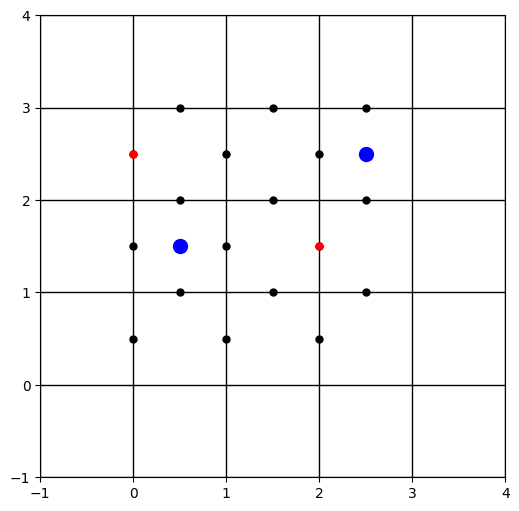

In [15]:
from Datavis import pp_code_Z

L = 3
error_probability = 0.1

Hz = toric_code_z_stabilisers(L)
logZ = toric_code_z_logicals(L)
noise = (np.random.random(Hz.shape[1]) < error_probability).astype(np.uint8)

syndrome = Hz@noise % 2
actual_logicals_flipped = logZ@noise % 2

# reshape syndrome into a 2D array
syn2D = syndrome.reshape((L, L))
# reshape npise into a 2D array
noi2D = noise.reshape((2*L, L))

print("Noise: \n", noi2D)
print("Syndrome: \n", syn2D)
print("Actual logicals flipped: ", actual_logicals_flipped)

# concatenate the syndrome and noise arrays
obs = np.concatenate((syndrome, noise), axis=0)

pp_code_Z(syn2D, noi2D)

In [16]:
from Datavis import pp_code_Z, pp_code_X

L = 3


error_probability = 0.1


Hz = toric_code_z_stabilisers(L).toarray()
logZ = toric_code_z_logicals(L)
noise = (np.random.random(Hz.shape[1]) < error_probability).astype(np.uint8)
#noise = [1,0,1,0,1,0,0,0]
#        1,2,3,4,5,6,7,8

syndrome = Hz@noise % 2
actual_logicals_flipped = logZ@noise % 2

print(f"noise:\n {noise}",'\n')

print(f"parity matrix:\n{Hz}", '\n')


print(f"logical operators\n", logZ.toarray(),'\n')

print("syndrome", syndrome,'\n')

print("logicals flipped", actual_logicals_flipped,'\n')

noise:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

parity matrix:
[[1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
 [1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
 [0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1]] 

logical operators
 [[1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]] 

syndrome [0 0 0 0 0 0 0 0 0] 

logicals flipped [0 0] 



In [17]:
for row, rownum in zip(Hz, range(len(Hz))):
    # print index of non-zero elements
    print(np.nonzero(row)[0]+1, chr(rownum+97))



[ 1  2 10 16] a
[ 2  3 11 17] b
[ 1  3 12 18] c
[ 4  5 10 13] d
[ 5  6 11 14] e
[ 4  6 12 15] f
[ 7  8 13 16] g
[ 8  9 14 17] h
[ 7  9 15 18] i


In [18]:
physical_qubits = np.arange(1, 2*L**2+1)
# arrange into 2D array
physical_qubits = physical_qubits.reshape((2*L, L))

# split in two
half = int(len(physical_qubits)/2)
left = physical_qubits[:half]
right = physical_qubits[half:]

# zip together
physical_qubits = np.array(list(zip(left, right)))
# reshape into 2D array
physical_qubits = physical_qubits.reshape(2*L, L)

#move last row to the top
physical_qubits = np.roll(physical_qubits, 1, axis=0)

for row, index in zip(physical_qubits, range (len(physical_qubits))):
    rowstring = ''
    for qubit in row:
        if qubit < 10:
            rowstring += '0' + str(qubit) + '  '
        else:
            rowstring += str(qubit) + '  '
    if index%2 == 0:
        print('  ' + rowstring)
    else:
        print(rowstring)

# syndrom is just the roll method once


  16  17  18  
01  02  03  
  10  11  12  
04  05  06  
  13  14  15  
07  08  09  


In [19]:

def arrange_x_syndrome(syndrome):
    L = int(np.sqrt(len(syndrome)))
    syndrome = syndrome.reshape((L, L))
    # bring last row to the top
    syndrome = np.roll(syndrome, 1, axis=0)
    syndrome = syndrome.flatten()
    return syndrome

def arrange_physical_qubits(qubits):
    # arrange into 2D array
    # sqrt length of qubits
    L = int(np.sqrt(len(qubits)/2))
    qubits = qubits.reshape((2*L, L))

    # split in two
    half = int(len(qubits)/2)
    left = qubits[:half]
    right = qubits[half:]

    # zip together
    qubits = np.array(list(zip(left, right)))
    # reshape into 2D array
    qubits = qubits.reshape(2*L, L)

    #move last row to the top
    qubits = np.roll(qubits, 1, axis=0)

    #flatten
    qubits = qubits.flatten()
    return qubits

syn = [1,2,3,4,5,6,7,8,9]
# convert to np array
syn = arrange_x_syndrome(np.array(syn))
print(syn.reshape((3,3)))

qb = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

qb = arrange_physical_qubits(np.array(qb))
print(qb.reshape((6,3)))


[[7 8 9]
 [1 2 3]
 [4 5 6]]
[[16 17 18]
 [ 1  2  3]
 [10 11 12]
 [ 4  5  6]
 [13 14 15]
 [ 7  8  9]]


logical operators
 [[1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]] 

Actual logicals flipped:  [0 0]


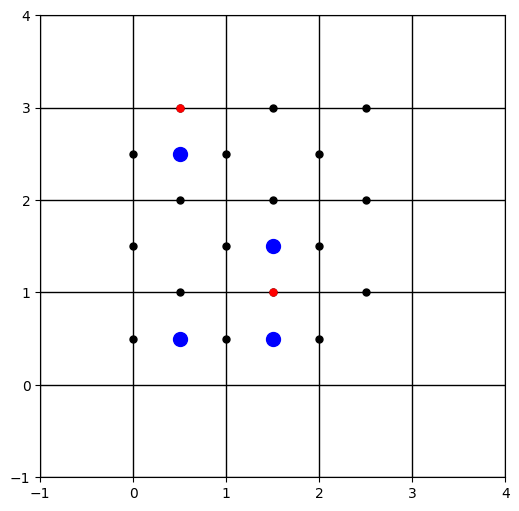

In [20]:
L = 3
error_probability = 0.1

Hz = toric_code_z_stabilisers(L)
logZ = toric_code_z_logicals(L)
noise = (np.random.random(Hz.shape[1]) < error_probability).astype(np.uint8)

syndrome = Hz@noise % 2
actual_logicals_flipped = logZ@noise % 2



#syndrome = arrange_syndrome(syndrome)
noise = arrange_physical_qubits(noise)

# reshape syndrome into a 2D array
syn2D = syndrome.reshape((L, L))
# reshape npise into a 2D array
noi2D = noise.reshape((2*L, L))


print(f"logical operators\n", logZ.toarray(),'\n')
print("Actual logicals flipped: ", actual_logicals_flipped)


# concatenate the syndrome and noise arrays
obs = np.concatenate((syndrome, noise), axis=0)

pp_code_Z(syn2D, noi2D)

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 1 1 0 1 1 0]
Noise: 
 [[1 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 0 0]
 [0 0 0]]
Syndrome: 
 [[1 1 0]
 [0 0 0]
 [1 1 0]]
Actual logicals flipped:  [0 0]


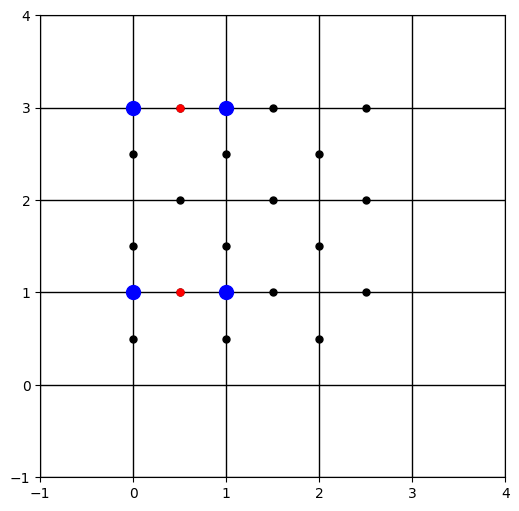

In [27]:


L = 3
error_probability = 0.1

Hx = toric_code_x_stabilisers(L)
logX = toric_code_x_logicals(L)
noise = (np.random.random(Hx.shape[1]) < error_probability).astype(np.uint8)

print(noise)

syndrome = Hx@noise % 2
actual_logicals_flipped = logX@noise % 2

print(syndrome)

syndrome = arrange_x_syndrome(syndrome)
noise = arrange_physical_qubits(noise)

# reshape syndrome into a 2D array
syn2D = syndrome.reshape((L, L))
# reshape npise into a 2D array
noi2D = noise.reshape((2*L, L))

print("Noise: \n", noi2D)
print("Syndrome: \n", syn2D)
print("Actual logicals flipped: ", actual_logicals_flipped)

pp_code_X(syn2D, noi2D)

In [22]:
## commutivity check

L = 3
error_probability = 0.1

Hz = toric_code_z_stabilisers(L)
logZ = toric_code_z_logicals(L)

#print(f"parity matrix:\n{Hz.toarray()}, \n logZ:\n{logZ.toarray()}")

print(f"Hz * logZ:\n{(Hz@logZ.T).toarray()==(logZ@Hz.T).toarray().T}")

Hx = toric_code_x_stabilisers(L)
logX = toric_code_x_logicals(L)

print(f"Hx * logX:\n{(Hx@logX.T).toarray()==(logX@Hx.T).toarray().T}")





Hz * logZ:
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]
Hx * logX:
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]


In [23]:
print(f"logicals product:\n{(logZ@logX.T).toarray()}")
print(f"logicals product:\n{(logX@logZ.T).toarray()}")

logicals product:
[[1 0]
 [0 1]]
logicals product:
[[1 0]
 [0 1]]
